In [103]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

In [115]:
# Source term
class Source(UserExpression):
    def eval(self, values, x):
        dx = x[0] - .5
        dy = x[1] - .5
        values[0] = x[0] * sin(5.0*DOLFIN_PI*x[1]) \
                    + exp(-(dx*dx + dy*dy)/0.02)
    def value_shape(self):
        return ()
    
class PeriodicSource(UserExpression):
    def eval(self, values, x):
        values[0] = sin(2 *DOLFIN_PI * x[0]) * cos(2*DOLFIN_PI*x[1])
    def value_shape(self):
        return ()
    
kappa = PeriodicSource()

In [205]:
# Subdomain for Dirichlet boundary condition
class FixTopAndBottom(SubDomain):
    def inside(self, x, on_boundary):
        return (near(x[1], 0, DOLFIN_EPS_LARGE)\
                or near(x[1], 1, DOLFIN_EPS_LARGE)) and on_boundary
    
class FixBottomLeft(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0, 1E-10) and near(x[1], 0, 1E-10) and on_boundary

In [248]:
# Subdomain for Periodic boundary condition
class PeriodicBoundary(SubDomain):
    # Left boundary is "tangent domain" G
    def inside(self, x, on_boundary):
        left = near(x[0], 0, 1E-10)
        bottom = near(x[1], 0, 1E-10)
        bottom_left = near(x[0], 0, 1E-10) \
                and near(x[1], 0, 1E-10)
        bottom_right = near(x[0], 1, 1E-10) and near(x[1], 0, 1E-10)
        top_left = near(x[0], 0, 1E-10) and near(x[1], 1, 1E-10)
        top_right = near(x[0], 1, 1E-10) and near(x[1], 1, 1E-10)
        
        return left and bottom and \
            (not (bottom_left or bottom_right 
                  or top_left or top_right)) and on_boundary
    
    # Map right boundary (H) to the left boundary (G)
    def map(self, x, y):
        if near(x[0], 1.0, 1E-10) and (not near(x[1], 1.0, 1E-10)) and (not near(x[1], 0.0, 1E-10)):
            y[0] = x[0] - 1.0
            y[1] = x[1]
        elif near(x[1], 1.0, 1E-10) and (not near(x[0], 1.0, 1E-10)) and (not near(x[0], 0.0, 1E-10)):
            y[0] = x[0]
            y[1] = x[1] - 1.0
        else:
            y[0] = x[0] - 1.0
            y[1] = x[1] - 1.0
        
# Create an instance of periodic boundary condition
# pbc = PeriodicBoundary()

A 2D mesh is created using built-in class UnitSquareMesh, and we define a finite element function space relative to this mesh. Notice the fourth argument of FunctionSpace. It specifies that all functions in V have periodic boundaries defined by "pbc". Also notice that in order for periodic boundary conditions to work correctly it is necessary that the mesh nodes on the periodic boundaries match up. This is automatically satisfied for UnitSquareMesh but may require extra care with more general meshes (especially externally generated ones).

In [259]:
# Create mesh and finite element
mesh = UnitSquareMesh(16, 16, "crossed")
V = FunctionSpace(mesh, "CG", 2, 
                  constrained_domain=PeriodicBoundary()) # CG = continuous Galerkin

In [260]:
# Create Dirichlet boundary condition
bc0 = DirichletBC(V, 0, FixBottomLeft())

In [261]:
coef = Constant(np.array([[1, 0], [0, 1]]))

In [262]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = PeriodicSource(element = V.ufl_element())
a = dot(grad(v), dot(coef, grad(u))) * dx
L = f*v*dx

In [273]:
# Solve the variational problem for solution
u = Function(V)
solve(a == L, u, [])

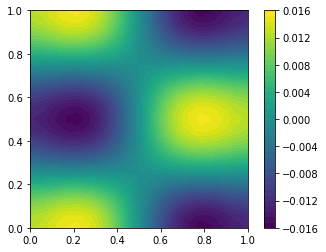

In [274]:
plt.colorbar(plot(u))

In [275]:
np.argmin(np.abs(u.vector().get_local()))

589

In [276]:
assemble(project(kappa, V)*dx)

-4.065758146820642e-18

In [277]:
u.vector().get_local()[589]

6.384521756327985e-05

In [269]:
mesh.coordinates()[589]

IndexError: index 589 is out of bounds for axis 0 with size 545